<a href="https://colab.research.google.com/github/YBenPan/oil-forecast/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
%matplotlib inline

In [ ]:
!rm -rf *
#!ls -a
!git clone https://github.com/YBenPan/oil-forecast.git 
#!ls oil-forecast/data

Cloning into 'oil-forecast'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [3]:
df = pd.read_csv("oil-forecast/Oil3Data.csv", sep = ",", index_col = 'Date', parse_dates = True)
df = df.dropna(axis = 0)

NameError: ignored

In [ ]:
df = df[1000:]
df

,Stock,Stock_change,Price,Price_change,Days_of_Supply,DoS_change
Date,,,,,,
2009-03-13,1023756,0.002989,45.68,0.055941,23.7,0.008511
2009-03-20,1026592,0.002770,49.46,0.082750,23.8,0.004219
2009-03-27,1033007,0.006249,53.45,0.080671,24.1,0.012605
2009-04-03,1035682,0.002590,50.32,-0.058559,24.1,0.000000
2009-04-10,1043847,0.007884,50.46,0.002782,24.6,0.020747
...,...,...,...,...,...,...
2020-10-23,1391224,-0.002780,40.56,0.001481,36.6,0.013850
2020-10-30,1376547,-0.010550,37.50,-0.075444,36.2,-0.010929
2020-11-06,1365069,-0.008338,37.91,0.010933,36.6,0.011050


Build ARIMA model: 

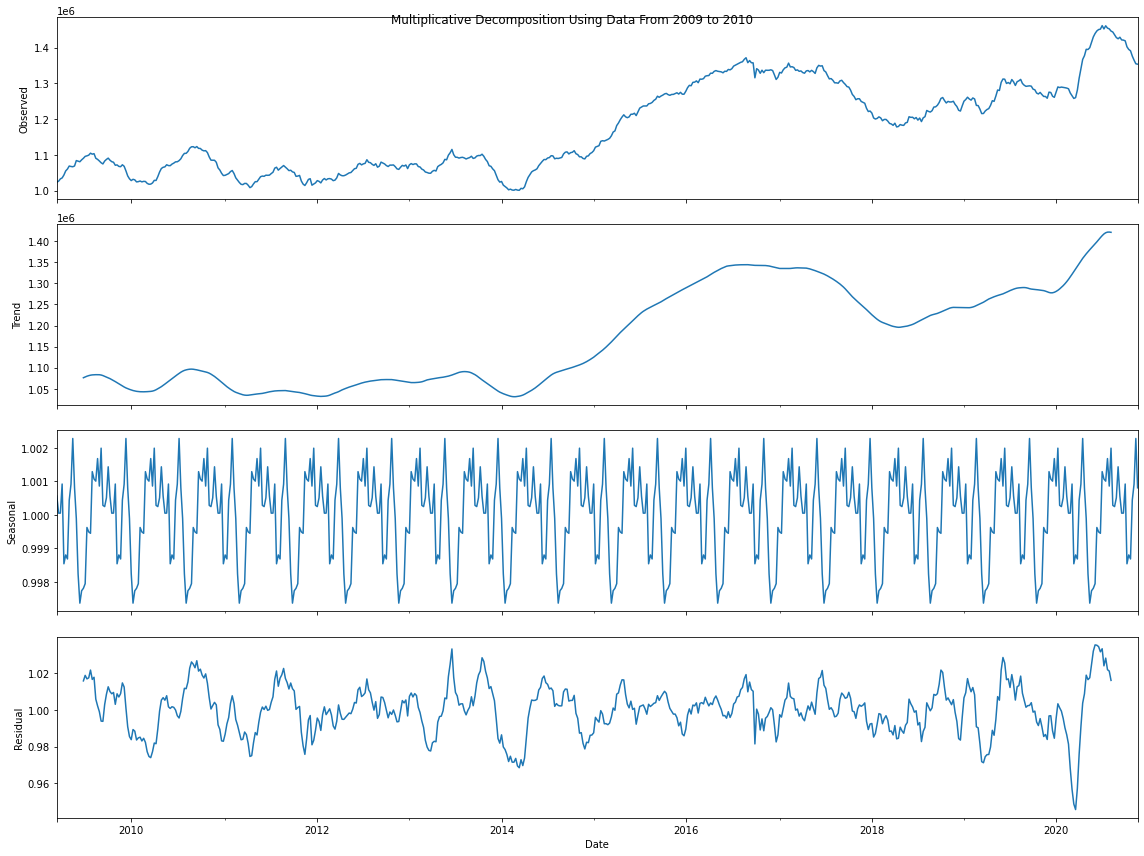

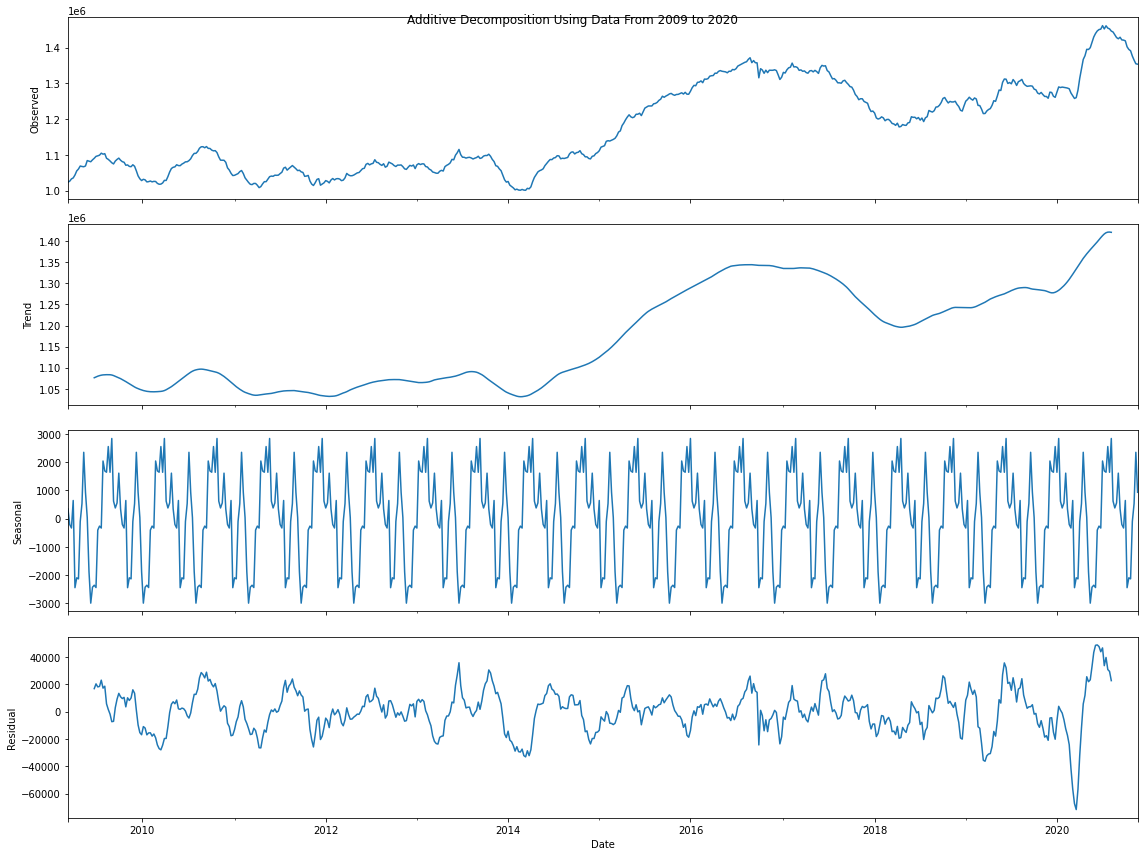

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

additive_decomposition = seasonal_decompose(df['Stock'], model = 'additive', freq = 30)
multiplicative_decomposition = seasonal_decompose(df['Stock'], model = 'multiplicative', freq = 30)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition Using Data From 2009 to 2010')
additive_decomposition.plot().suptitle('Additive Decomposition Using Data From 2009 to 2020')
#plt.show()

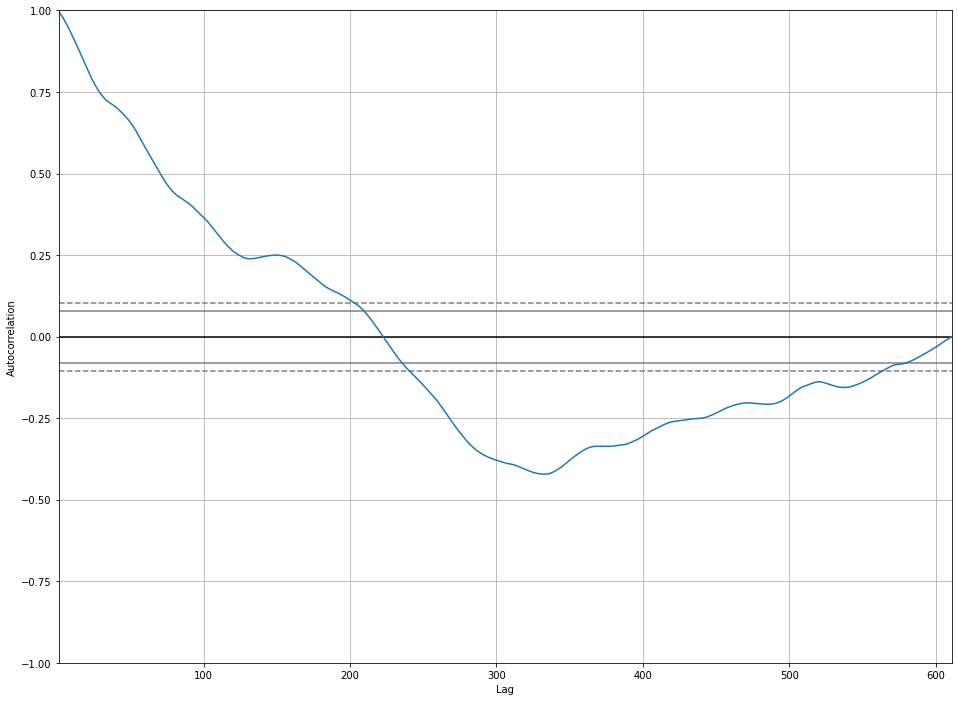

In [ ]:
from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(df['Stock'])

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df['Stock'], order = (2, 1, 2), freq = 'W-FRI')
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Stock   No. Observations:                  610
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6232.324
Method:                       css-mle   S.D. of innovations           6619.454
Date:                Thu, 18 Mar 2021   AIC                          12476.648
Time:                        12:32:06   BIC                          12503.129
Sample:                    03-20-2009   HQIC                         12486.949
                         - 11-20-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           526.0456    398.213      1.321      0.187    -254.437    1306.528
ar.L1.D.Stock     1.8323      0.064     28.728      0.000       1.707       1.957
ar.L2.D.Stock    -0.8429      0.065    -

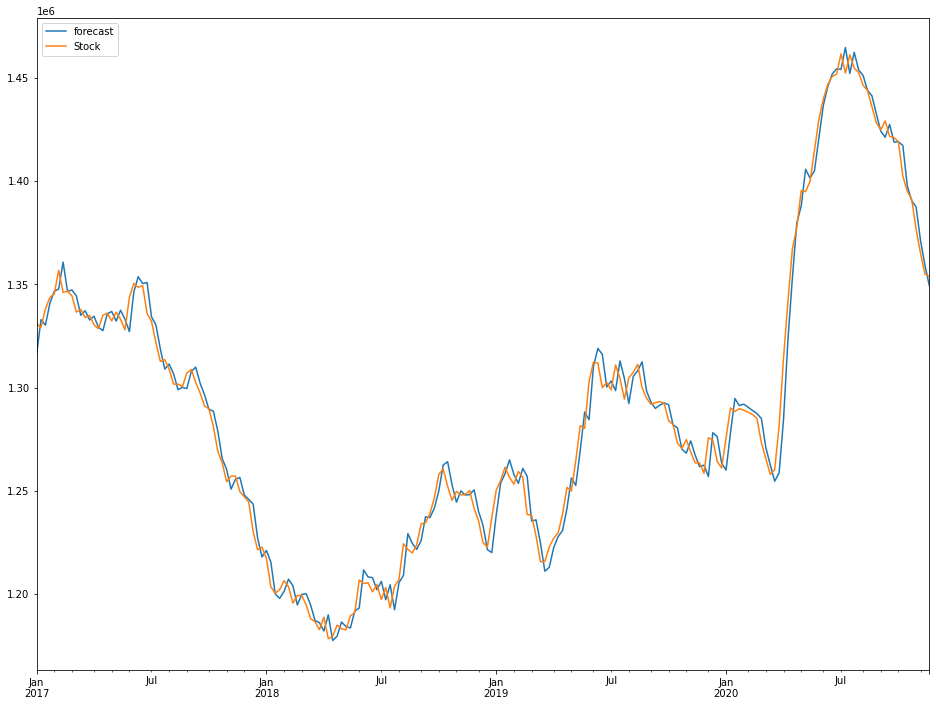

In [ ]:
model_fit.plot_predict(dynamic = False, start = '2017-01-06')
plt.show()

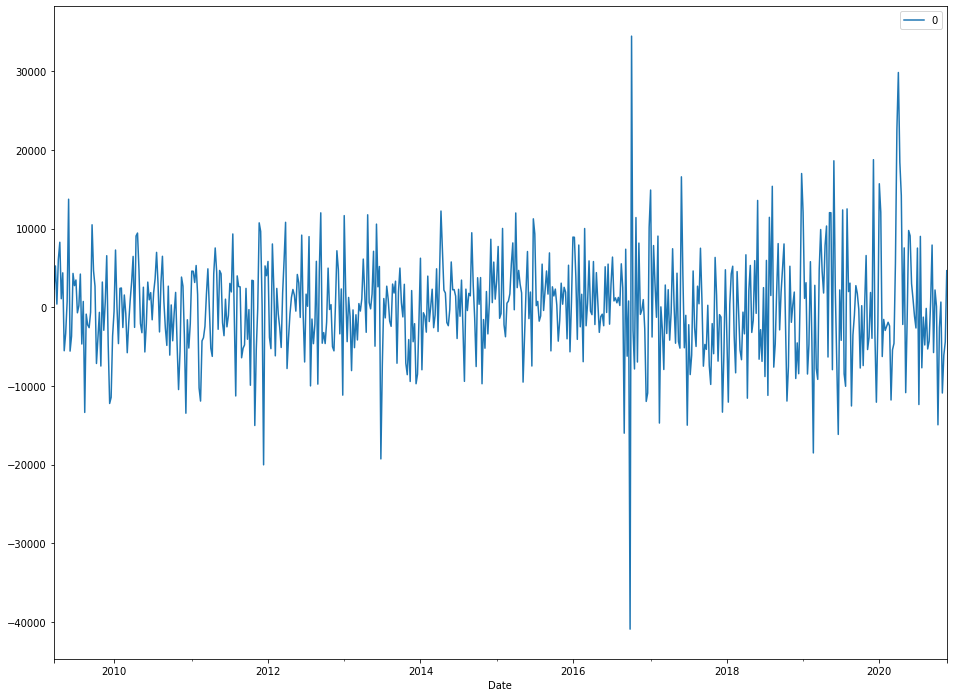

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()

Model Validation:

In [ ]:
dflen = len(df)
testlen = round(dflen / 5)
trainlen = dflen - testlen
train = df[0:trainlen]
test = df[trainlen: dflen]
#train
#test

In [ ]:
model = ARIMA(df['Stock'], order = (1, 2, 2))
model_fit = model.fit()
output = model_fit.forecast()
#output[0][0]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [ ]:
def build(train, test):
    history = train
    predictions = pd.DataFrame()
    for i in range(len(test)):
        model = ARIMA(history['Stock'], order = (1, 1, 2), freq = 'W-FRI')
        model_fit = model.fit()
        output = model_fit.forecast()
        predicted = output[0][0]
        added_obj = test.iloc[i]
        predicted_series = pd.Series([predicted])
        added_obj = added_obj.append(predicted_series) 
        added_obj.index = ['Stock', 'Stock_change', 'Price', 'Price_change', 'Days of Supply', 'DoS_change', 'Predicted_Stock']
        added_obj = added_obj.rename(i)
        predictions = predictions.append(added_obj)
        history = history.append(test.iloc[i])
    return predictions

In [ ]:
res = build(train, test)
res = res[['Stock', 'Stock_change', 'Predicted_Stock', 'Price', 'Price_change', 'Days of Supply', 'DoS_change']]

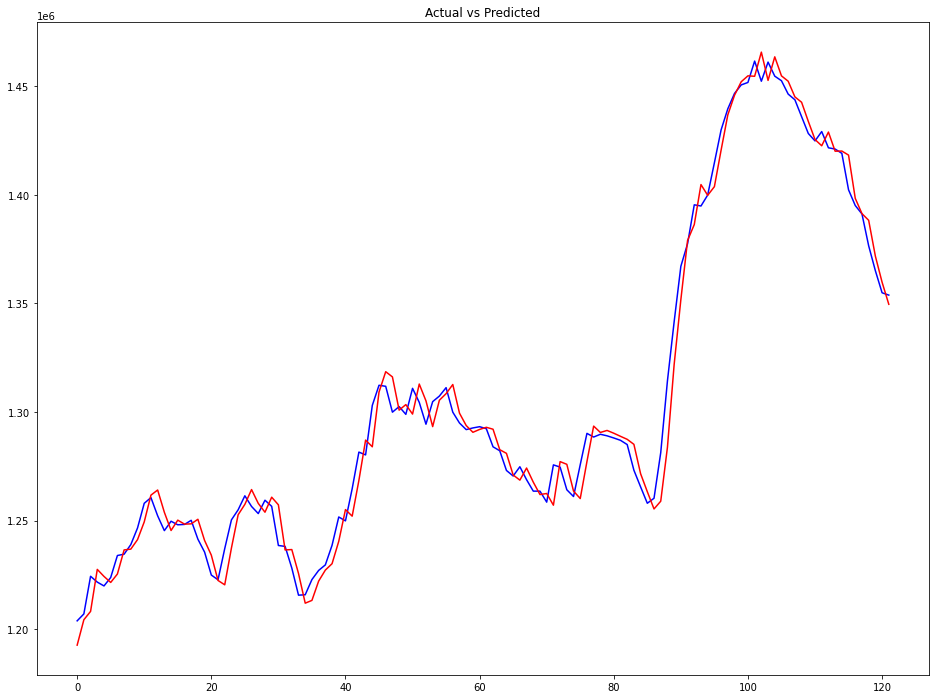

In [ ]:
pre1 = res['Stock']
pre2 = res['Predicted_Stock']
pre3 = res.index
plt.title("Actual vs Predicted")
plt.plot(pre3, pre1, label = "Actual", color = "Blue")
plt.plot(pre3, pre2, label = "Predicted", color = "Red")

In [ ]:
print("Root Mean Squared Error:", math.sqrt(metrics.mean_squared_error(res['Predicted_Stock'], res['Stock'])))

Root Mean Squared Error: 8716.67372678536


In [ ]:
x_train = df.loc[:, 'Stock'].values
#print(x_train[:15])
#print(type(x_train))
y_train = df.loc[:, 'Price'].values
#print(y_train)
#x_test = res.loc[:, 'Predicted_Stock'].values
x_test = res.loc[:, 'Predicted_Stock'].values
#print(x_test)
y_test = res.loc[:, 'Price'].values
#print(y_test)

In [ ]:
#x_train = x_train.reshape(-1, 1)
#x_test = x_test.reshape(-1, 1)

Linear Regression model

In [ ]:
#regressor = LinearRegression()
regressor = np.poly1d(np.polyfit(x_train, y_train, 3))
#print(regressor.coef_)
#print(regressor.intercept_)

Text(0, 0.5, 'Price')

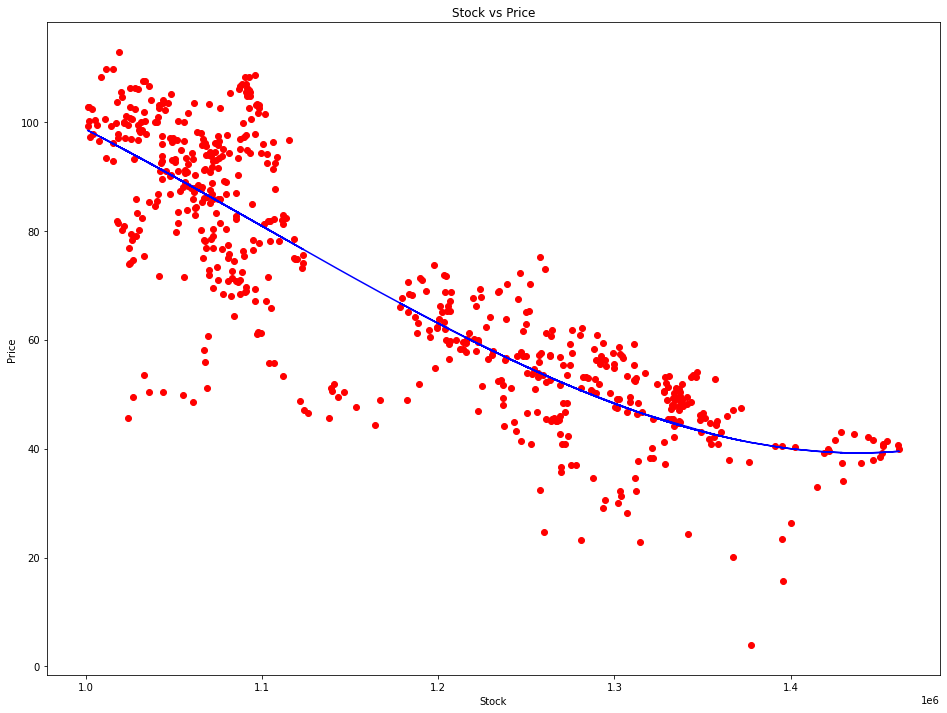

In [ ]:
plt.scatter(x_train, y_train, color = "red")
plt.plot(x_train, regressor(x_train), color = "blue")
plt.title("Stock vs Price")
plt.xlabel("Stock")
plt.ylabel("Price")

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_train, regressor(x_train)))

0.7362518437146544


In [ ]:
predicted = regressor(x_test)
res['Predicted_Price'] = predicted
#res
#print(type(predicted))

In [ ]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, predicted))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, predicted))
print("Root Mean Squared Error:", math.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error: 7.082059427900512
Mean Squared Error: 98.31710572023674
Root Mean Squared Error: 9.915498258798532


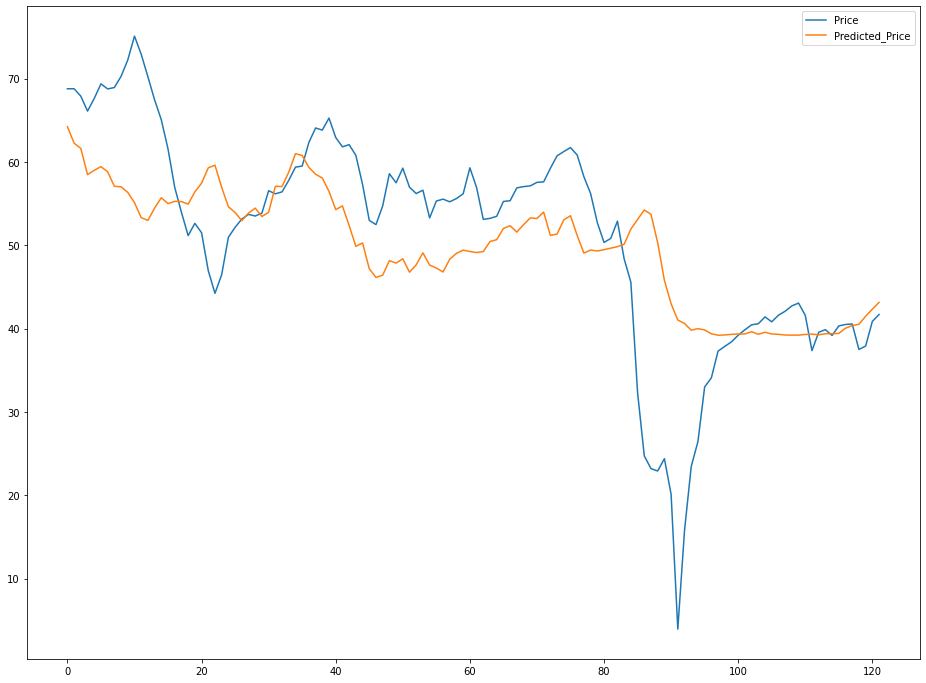

In [ ]:
res.plot(y = ["Price", "Predicted_Price"])

Model Evaluation. Predicts the Price

In [ ]:
model = ARIMA(df['Stock'], order = (1, 2, 2))
model_fit = model.fit()
output = model_fit.forecast()
newStock = output[0][0]
newPrice = regressor(newStock)
newPrice

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


43.08300693219729